# Latent semantic analysis, no tears

[Latent semantic analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis) (LSA) is a natural language processing (NLP) technique to bridge terms and documents through concepts. The idea is that there are hidden concepts (latent concepts) through which words and documents are related. The heart and soul of LSA is the application of [singular value decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition) (SVD) to a term-document matrix. In this tutorial, we will see how SVD is applied to documents and terms in those documents to flush out the latent concepts. 

# The data

Assume we have 6 documents labelled, d1, d2, d3, d4, d5, and d6. The first three documents, d1, d2, and d3 are about computer programming, and the last three documents are about financial investment. Assume each of these documents have titles, and the keywords in these titles span the terms

* programming
* development
* language
* money
* finance
* currency

We can build a term-document matrix of these terms and documents where the each row correspond to one of the unique terms, and the columns correspond to one of the documents. The term-document matrix is of dimensions, m x n = 6 x 6, corresponding to 6 terms (m rows) and 6 documents (n columns).

The dataframe, df, below, builds this term-document matrix; notice that the columns are labelled d1, d2, ..., d6, and the rows are indexed from programming, development, ..., currency. This term-document matrix is essentially a boolean matrix where the i-th, j-th entry is 1 if the i-th term shows up in the j-th document, otherwise, it is zero. Of course, you can create a different term-document matrix based on word frequency or something else like [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf). Either way, the concepts and methods still apply to the term-document matrix. Furthermore, we convert df to A (convert the dataframe to a matrix); meaning, df = A.

Notice that we have a query document, q, for which we want to find similar documents. Later, we will transform the documents into data points in latent space, as well as q, and perform a search in latent space to find documents that are similar to q conceptually.

In [1]:
import pandas as pd
import numpy as np

def print_matrix(m, name):
    def format_num(n):
        x = 0 if n == 0 or n == -0 else n
        if x < 0:
            return '{:.2f}'.format(x)
        else:
            return ' {:.2f}'.format(x)
        
    num_rows = m.shape[0]
    num_cols = m.shape[1]
    print('{} ({} x {})'.format(name, m.shape[0], m.shape[1]))
    for r in range(num_rows):
        s = ','.join([format_num(n) for n in m[r]])
        print(s)

df = pd.DataFrame(
    data={
        'd1': [1, 1, 0, 0, 0, 0],
        'd2': [1, 1, 1, 0, 0, 0],
        'd3': [1, 0, 1, 0, 0, 0],
        'd4': [0, 0, 0, 1, 1, 0],
        'd5': [0, 0, 0, 1, 1, 1],
        'd6': [0, 0, 0, 1, 0, 1]
    }, 
    index=['programming', 'development', 'language', 'money', 'finance', 'currency'])

A = df.as_matrix()
q = np.array([1, 0, 0, 0, 0, 0]).reshape(-1, 1)

print_matrix(A, 'A')
print_matrix(q, 'q')

A (6 x 6)
 1.00, 1.00, 1.00, 0.00, 0.00, 0.00
 1.00, 1.00, 0.00, 0.00, 0.00, 0.00
 0.00, 1.00, 1.00, 0.00, 0.00, 0.00
 0.00, 0.00, 0.00, 1.00, 1.00, 1.00
 0.00, 0.00, 0.00, 1.00, 1.00, 0.00
 0.00, 0.00, 0.00, 0.00, 1.00, 1.00
q (6 x 1)
 1.00
 0.00
 0.00
 0.00
 0.00
 0.00


# Singular value decomposition

We apply SVD to A, such that $A = USV'$. Note the following.

* $U$ holds the coordinates of the individual terms.
* $S$ represents the latent concepts.
* $V$ holds the coordinates of the individual documents.
* $VT$, or, equivalently, $V'$, is $V$ transposed.

Note that $S$ stores the eigenvalues, $U$ stores the left-eigenvectors and $V'$ stores the right-eigenvectors.

In [2]:
from numpy.linalg import svd

U, S, VT = svd(A, full_matrices=False)
S = np.diag(S)
V = VT.transpose()

print_matrix(U, 'U')
print_matrix(S, 'S')
print_matrix(V, 'V')
print_matrix(VT, 'VT')

U (6 x 6)
-0.71, 0.00,-0.00, 0.00,-0.71, 0.00
-0.50, 0.00,-0.71, 0.00, 0.50, 0.00
-0.50, 0.00, 0.71, 0.00, 0.50, 0.00
 0.00,-0.71, 0.00,-0.00, 0.00,-0.71
 0.00,-0.50, 0.00,-0.71, 0.00, 0.50
 0.00,-0.50, 0.00, 0.71, 0.00, 0.50
S (6 x 6)
 2.41, 0.00, 0.00, 0.00, 0.00, 0.00
 0.00, 2.41, 0.00, 0.00, 0.00, 0.00
 0.00, 0.00, 1.00, 0.00, 0.00, 0.00
 0.00, 0.00, 0.00, 1.00, 0.00, 0.00
 0.00, 0.00, 0.00, 0.00, 0.41, 0.00
 0.00, 0.00, 0.00, 0.00, 0.00, 0.41
V (6 x 6)
-0.50, 0.00,-0.71, 0.00,-0.50, 0.00
-0.71, 0.00, 0.00, 0.00, 0.71, 0.00
-0.50, 0.00, 0.71, 0.00,-0.50, 0.00
 0.00,-0.50, 0.00,-0.71, 0.00,-0.50
 0.00,-0.71, 0.00, 0.00, 0.00, 0.71
 0.00,-0.50, 0.00, 0.71, 0.00,-0.50
VT (6 x 6)
-0.50,-0.71,-0.50, 0.00, 0.00, 0.00
 0.00, 0.00, 0.00,-0.50,-0.71,-0.50
-0.71, 0.00, 0.71, 0.00, 0.00, 0.00
 0.00, 0.00, 0.00,-0.71, 0.00, 0.71
-0.50, 0.71,-0.50, 0.00, 0.00, 0.00
 0.00, 0.00, 0.00,-0.50, 0.71,-0.50


# Choose k << n

We now need to choose a k that is way less than n (the number of terms), $k << n$. Typically, you could use a few of the [techniques below](https://en.wikipedia.org/wiki/Factor_analysis) for starters.

* Kaiser criterion
* Scree plot
* Proportion of variance explained

In our case, we arbitrarily choose k=3.

In [3]:
from numpy.linalg import inv

k = 3
U_k = U[:, 0:k]
S_k = inv(S[0:k, 0:k])
V_k = V[:, 0:k]
VT_k = VT[0:k, :]

print_matrix(U_k, 'U_k')
print_matrix(S_k, 'S_k^-1')
print_matrix(V_k, 'V_k')
print_matrix(VT_k, 'VT_k')

U_k (6 x 3)
-0.71, 0.00,-0.00
-0.50, 0.00,-0.71
-0.50, 0.00, 0.71
 0.00,-0.71, 0.00
 0.00,-0.50, 0.00
 0.00,-0.50, 0.00
S_k^-1 (3 x 3)
 0.41, 0.00, 0.00
 0.00, 0.41, 0.00
 0.00, 0.00, 1.00
V_k (6 x 3)
-0.50, 0.00,-0.71
-0.71, 0.00, 0.00
-0.50, 0.00, 0.71
 0.00,-0.50, 0.00
 0.00,-0.71, 0.00
 0.00,-0.50, 0.00
VT_k (3 x 6)
-0.50,-0.71,-0.50, 0.00, 0.00, 0.00
 0.00, 0.00, 0.00,-0.50,-0.71,-0.50
-0.71, 0.00, 0.71, 0.00, 0.00, 0.00


# Plot how influential are latent space dimensions to documents

Here, we plot how the concepts (dimensions in latent space) relate to each document. Note that dimension 1 relates to documents 1, 2, and 3, and dimension 2 relates to documents 4, 5, 6.

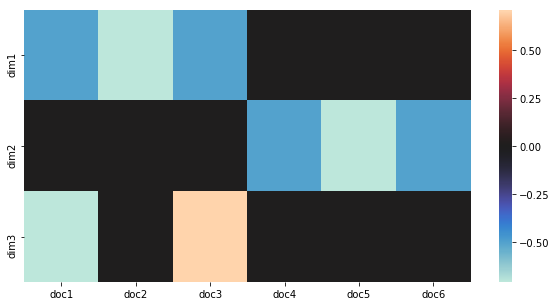

In [4]:
%matplotlib inline

import matplotlib.pylab as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
x_labels = ['doc{}'.format(i+1) for i in range(VT_k.shape[1])]
y_labels = ['dim{}'.format(i+1) for i in range(VT_k.shape[0])]
sns.heatmap(VT_k, xticklabels=x_labels, yticklabels=y_labels, center=0.0, ax=ax)
plt.show()

# Do clustering on the documents in latent space

We can also cluster the documents in latent space. Note that we already know there are 2 clusters, so we use k-means to cluster and specify 2 clusters.

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(V_k)
print(kmeans.labels_)
print(kmeans.cluster_centers_)

[1 1 1 0 0 0]
[[ 0.00000000e+00 -5.69035594e-01  0.00000000e+00]
 [-5.69035594e-01  0.00000000e+00  5.55111512e-17]]


# Plot terms and documents in latent space

Here we plot the terms and documents in the latent space. Since we have selected 3 dimensions in latent space, we will plot the terms and documents with dimension 1 vs dimension 2, dimension 1 vs dimension 3, and dimension 2 vs dimension 3. Note that in the plot of dimension 1 vs dimension 2, all the programming books cluster together with the programming keywords, and all the financial books cluster together with the financial keywords.

3
n = 3, num_cols = 2, num_rows = 2


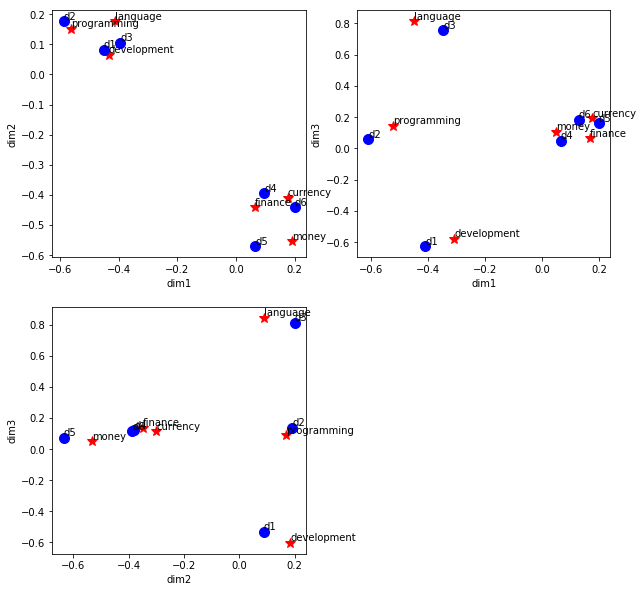

In [6]:
from scipy.special import binom

def plot_terms_docs(x_index, y_index, U, V, df, ax):
    def get_jitter():
        return np.random.choice(np.linspace(0.05, 0.2, 20), 1)
    
#     print('{} vs {}'.format(x_index, y_index))
#     print_matrix(U, 'U');
#     print_matrix(V, 'V')
    
    for i in range(len(df.index)):
        term = df.index[i]
        x = U[i][x_index] + get_jitter()
        y = U[i][y_index] + get_jitter()
#         print('({},{}) for {}'.format(x, y, term))

        ax.plot(x, y, color='red', marker='*', markersize=10.0)
        ax.annotate(term, xy=(x, y), textcoords='data', horizontalalignment='left', verticalalignment='bottom')

    for i in range(V.shape[0]):
        doc = 'd{}'.format(i + 1)
        x = V[i][x_index] + get_jitter()
        y = V[i][y_index] + get_jitter()
#         print('({},{}) for {}'.format(x, y, doc))

        ax.plot(x, y, color='blue', marker='o', markersize=10.0)
        ax.annotate(doc, xy=(x, y), textcoords='data', horizontalalignment='left', verticalalignment='bottom')
        
n = U_k.shape[1]
num_cols = 2
num_rows = 1
num_combinations = int(binom(n, num_cols))
is_odd = False
print(num_combinations)
if num_combinations % num_cols == 0:
    num_rows = num_combinations / num_cols
else:
    num_rows = num_combinations / num_cols + 1
    is_odd = True

print('n = {}, num_cols = {}, num_rows = {}'.format(n, num_cols, num_rows))

fig, axes = plt.subplots(num_rows, num_cols, sharex=False, sharey=False, figsize=(10, 10))
if is_odd is True:
    axes[-1, -1].axis('off')
axes = axes.ravel()
ax_counter = 0

for i in range(n):
    for j in range(n):
        if j > i:
            ax = axes[ax_counter]
            plot_terms_docs(i, j, U_k, V_k, df, ax)
            ax.set_xlabel('dim{}'.format(i + 1))
            ax.set_ylabel('dim{}'.format(j + 1))

            ax_counter += 1

# Query for similar documents in latent space

This example shows how to convert a new document into latent space and then query for similar documents. Note that the new document has the term "programming", thus, its cosine-similarity is closer to the programming documents than the financial ones.

In [7]:
print_matrix(q.transpose().dot(U_k).dot(S_k), 'q in latent space')

q in latent space (1 x 3)
-0.29, 0.00,-0.00


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

print_matrix(cosine_similarity(q.transpose().dot(U_k).dot(S_k), V_k), 'q similarities to docs in latent space')

q similarities to docs in latent space (1 x 6)
 0.58, 1.00, 0.58, 0.00, 0.00, 0.00


# References

* [Latent semantic analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis)
* [Latent Semantic Indexing (LSI) An Example](http://www1.se.cuhk.edu.hk/~seem5680/lecture/LSI-Eg.pdf)
* [Latent Semantic Analysis (LSA) Tutorial](https://technowiki.wordpress.com/2011/08/27/latent-semantic-analysis-lsa-tutorial/)
* [pyLDAvis](http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb)
* [Using Gensim for LDA](http://christop.club/2014/05/06/using-gensim-for-lda/)
* [LSA / PLSA / LDA](https://cs.stanford.edu/~ppasupat/a9online/1140.html)
* [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)
* [Scikit-Learn Cosine Similarity](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)